# Basic tutorial

The goal of this tutorial is to give you an idea of how AiiDA helps you in executing data-driven workflows.
At the end of this tutorial, you will know how to:

- Store data in the database and subsequently retrieve it.
- Decorate a Python function such that its inputs and outputs are automatically tracked.
- Run and monitor the status of processes.
- Explore and visualize the provenance graph.


In [1]:
%load_ext aiida
%aiida

Loaded AiiDA DB environment - profile name: fair-workflows.

## Data nodes

Before running any calculations, let's create and store a *data node*.
AiiDA implements data node types for the most common types of data (int, float, str, etc.), which you can extend with your own (composite) data node types if needed.
For this tutorial, we'll keep it very simple, and start by initializing an `Int` node and assigning it to the `x` variable:

In [2]:
from aiida import orm

x = orm.Int(2)

We can check the contents of the `node` variable like this:

In [3]:
x

<Int: uuid: 7b9b9be8-fb73-4d3a-beb0-72ecb66185ac (unstored) value: 2>

Quite a bit of information on our freshly created node is returned:

- The data node is of the type `Int`
- The node has the *universally unique identifier* (**UUID**)
- The node is currently not stored in the database `(unstored)`
- The integer value of the node is `2`

Let's store the node in the database:

In [4]:
x.store()

<Int: uuid: 7b9b9be8-fb73-4d3a-beb0-72ecb66185ac (pk: 1) value: 2>

As you can see, the data node has now been assigned a *primary key* (**PK**), a number that identifies the node in your database `(pk: 1)`.
The PK and UUID both reference the node with the only difference that the PK is unique *for your local database only*, whereas the UUID is a globally unique identifier and can therefore be used between *different* databases.
Use the PK only if you are working within a single database, i.e. in an interactive session and the UUID in all other cases.

> **Note**
> 
> The PK numbers shown throughout this tutorial assume that you start from a completely empty database.
> It is possible that the nodes' PKs will be different for your database!
>
> The UUIDs are generated randomly and are, therefore, **guaranteed** to be different.


Next, let's use the `verdi` command line interface (CLI) to check the data node we have just created:

In [5]:
%verdi node show 1

Property     Value
-----------  ------------------------------------
type         Int
pk           1
uuid         7b9b9be8-fb73-4d3a-beb0-72ecb66185ac
label
description
ctime        2024-08-06 11:33:01.997706+00:00
mtime        2024-08-06 11:33:06.554727+00:00


Once again, we can see that the node is of type `Int`, has its PK and UUID.
Besides this information, the `verdi node show` command also shows the (empty) `label` and `description`, as well as the time the node was created (`ctime`) and last modified (`mtime`).

> **Note**
> AiiDA already provides many standard data types, but you can also [create your own](https://aiida.readthedocs.io/projects/aiida-core/en/stable/topics/data_types.html#topics-data-types-plugin).


## Calculation functions

Once your data is stored in the database, it is ready to be used for some computational task.
For example, let's say you want to multiply two `Int` data nodes.
The following Python function:

```python
def multiply(x, y):
    return x * y
```

will give the desired result when applied to two `Int` nodes, but the calculation will not be stored in the provenance graph.
However, we can use a [Python decorator](https://docs.python.org/3/glossary.html#term-decorator) provided by AiiDA to automatically make it part of the provenance graph, as shown below:

In [7]:
from aiida import engine

@engine.calcfunction
def multiply(x, y):
    return x * y

This converts the `multiply` function into an AiIDA *calculation function*, the most basic execution unit in AiiDA.
Next, Let's create a new `Int` data node and assign it to the variable `y`, and then run the `multiply` function with the `x` and `y` data nodes as inputs:

In [8]:
y = orm.Int(3)

Now it's time to multiply the two numbers!

In [9]:
multiply(x, y)

<Int: uuid: 24cb2513-cd36-4bea-a939-63c8481183a8 (pk: 4) value: 6>

Success!
The `calcfunction`-decorated `multiply` function has multiplied the two `Int` data nodes and returned a new `Int` data node whose value is the product of the two input nodes.
Note that by executing the `multiply` function, all input and output nodes are automatically stored in the database:

In [10]:
y

<Int: uuid: 13bc9f20-4a18-48b7-b5a8-129bd1e55abd (pk: 2) value: 3>

We had not yet stored the data node assigned to the `y` variable, but by providing it as an input argument to the `multiply` function, it was automatically stored with PK = 2.
Similarly, the returned `Int` node with value 6 has been stored with PK = 4.

Let's look for the process we have just run using the `verdi` CLI:

In [11]:
%verdi process list -a

  PK  Created    Process label    ♻    Process State    Process status
----  ---------  ---------------  ---  ---------------  ----------------
   3  21s ago    multiply              ⏹ Finished [0]

Total results: 1

Report: ♻ Processes marked with check-mark were not run but taken from the cache.
Report: Add the option `-P pk cached_from` to the command to display cache source.
Report: Last time an entry changed state: 21s ago (at 11:33:21 on 2024-08-06)


We can see that our `multiply` calcfunction was created 1 minute ago, assigned the PK 3, and has `Finished`.

### Provenance graph
An AiiDA database does not only contain the results of your calculations, but also their inputs and each step that was executed to obtain them. All of this information is stored in the form of a directed acyclic graph (DAG).
Let's have a look at the provenance of this simple calculation.
The provenance graph can be automatically generated using the verdi CLI.
Let's generate the provenance graph for the `multiply` calculation function we have just run with PK = 3:

> **note**
> Remember that the PK of the `CalcJob` can be different for your database.

```console
$ verdi node graph generate 3
```

The command will write the provenance graph to a `.pdf` file.
Use your favorite PDF viewer to have a look.
It should look something like the graph shown below.

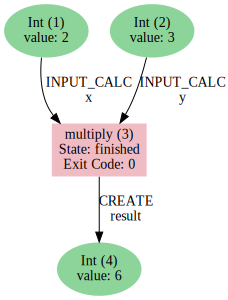

In [12]:
from aiida.tools.visualization import Graph
graph = Graph()
calc_node = orm.load_node(3)
graph.add_incoming(calc_node, annotate_links="both")
graph.add_outgoing(calc_node, annotate_links="both")
graph.graphviz

In the provenance graph, you can see different types of *nodes* represented by different shapes.
The green ellipses are `Data` nodes, and the rectangles represent *processes*, i.e. the calculations performed in your *workflow*.

The provenance graph allows us to not only see what data we have, but also how it was produced.

## CalcJobs
When running calculations that require an external code or run on a remote machine, a simple calculation function is no longer sufficient.
For this purpose, AiiDA provides the `CalcJob` process class.

To run a `CalcJob`, you need to set up two things: a `code` that is going to implement the desired calculation and a `computer` for the calculation to run on.

In the previous section, the `verdi presto` command automatically configures the local workstation as the `localhost` computer for you.

Now, let's set up the code we're going to use for the tutorial. The following command sets up a code with *label* `add` on the *computer* `localhost`, using the *plugin* `core.arithmetic.add`.


More details for how to [run external codes](https://aiida.readthedocs.io/projects/aiida-core/en/stable/howto/run_codes.html#how-to-run-codes) can be found in the AiiDA documentation.

In [13]:
%verdi code create core.code.installed --label add --computer=localhost --default-calc-job-plugin core.arithmetic.add --filepath-executable=/bin/bash -n

Success: Created InstalledCode<5>


A typical real-world example of a computer is a remote supercomputing facility.
Codes can be anything from a Python script to powerful *ab initio* codes such as Quantum Espresso or machine learning tools like Tensorflow.
Let's have a look at the codes that are available to us:

In [14]:
%verdi code list

Full label       Pk  Entry point
-------------  ----  -------------------
add@localhost     5  core.code.installed

Use `verdi code show IDENTIFIER` to see details for a code


You can see a single code `add@tutor`, with PK = 5, in the printed list.
This code allows us to add two integers together.
The `add@tutor` identifier indicates that the code with label `add` is run on the computer with label `tutor`.
To see more details about the computer, you can use the following `verdi` command:

In [15]:
%verdi computer show localhost

---------------------------  -------------------------------------------------------
Label                        localhost
PK                           1
UUID                         6fb174c6-391f-4b08-bd7a-ac119a3fffb0
Description                  Localhost automatically created by `verdi presto`
Hostname                     localhost
Transport type               core.local
Scheduler type               core.direct
Work directory               /home/nanohub/superstar54/.aiida/scratch/fair-workflows
Shebang                      #!/bin/bash
Mpirun command               mpirun -np {tot_num_mpiprocs}
Default #procs/machine       1
Default memory (kB)/machine
Prepend text
Append text
---------------------------  -------------------------------------------------------


We can see that the *Work directory* has been set up as the `work` subdirectory of the current directory.
This is the directory in which the calculations running on the `localhost` computer will be executed.

> **note**
> You may have noticed that the PK of the `localhost` computer is 1, same as the `Int` node we created at the start of this tutorial.
> This is because different entities, such as nodes, computers and groups, are stored in different tables of the database.
> So, the PKs for each entity type are unique for each database, but entities of different types can have the same PK within one database.

Let's now load the `add@localhost` code using its label:

In [16]:
code = orm.load_code(label='add')
code

<InstalledCode: Remote code 'add' on localhost pk: 5, uuid: 239759d1-2784-4129-bba2-3e4aabfbcc8d>

Every code has a convenient tool for setting up the required input, called the *builder*.
It can be obtained by using the `get_builder` method:

In [17]:
builder = code.get_builder()
builder

Process class: ArithmeticAddCalculation
Inputs:
code: add@localhost
metadata:
  options:
    stash: {}
monitors: {}


Using the builder, you can easily set up the calculation by directly providing the input arguments.
Let's use the `Int` node that was created by our previous `calcfunction` as one of the inputs and a new node as the second input:

In [18]:
builder.x = orm.load_node(pk=4)
builder.y = orm.Int(5)
builder

Process class: ArithmeticAddCalculation
Inputs:
code: add@localhost
metadata:
  options:
    stash: {}
monitors: {}
x: 6
y: 5


In case that your nodes' PKs are different and you don't remember the PK of the output node from the previous calculation, check the provenance graph you generated earlier and use the UUID of the output node instead:

```ipython
In [3]: builder.x = orm.load_node(uuid='42541d38')
   ...: builder.y = orm.Int(5)
```

Note that you don't have to provide the entire UUID to load the node.
As long as the first part of the UUID is unique within your database, AiiDA will find the node you are looking for.

> **note**
> One nifty feature of the builder is the ability to use tab completion for the inputs.
> Try it out by typing `builder.` + `<TAB>` in the verdi shell.

To execute the `CalcJob`, we use the `run` function provided by the AiiDA engine, and wait for the process to complete:

In [19]:
engine.run(builder)

{'remote_folder': <RemoteData: uuid: 39a0b7ab-026a-4f9c-9579-f2233dc4651d (pk: 8)>,
 'retrieved': <FolderData: uuid: 35d7d124-52af-495c-a514-3cfe7983d6af (pk: 9)>,
 'sum': <Int: uuid: 7a88895e-b6d8-4cfa-8f96-a8c7c4617a0e (pk: 10) value: 11>}

Besides the sum of the two `Int` nodes, the calculation function also returns two other outputs: one of type `RemoteData` and one of type `FolderData`.
See the [topics section on calculation jobs](https://aiida.readthedocs.io/projects/aiida-core/en/stable/topics/calculations/usage.html#calculation-jobs) for more details.
Now, once more check for *all* processes:

In [20]:
%verdi process list -a

  PK  Created    Process label             ♻    Process State    Process status
----  ---------  ------------------------  ---  ---------------  ----------------
   3  47s ago    multiply                       ⏹ Finished [0]
   7  4s ago     ArithmeticAddCalculation       ⏹ Finished [0]

Total results: 2

Report: ♻ Processes marked with check-mark were not run but taken from the cache.
Report: Add the option `-P pk cached_from` to the command to display cache source.
Report: Last time an entry changed state: 1s ago (at 11:34:06 on 2024-08-06)


You should now see two processes in the list.
One is the `multiply` calcfunction you ran earlier, the second is the `ArithmeticAddCalculation` CalcJob that you have just run.
Grab the PK of the `ArithmeticAddCalculation`, and generate the provenance graph.
The result should look like the graph shown below.

```console
$ verdi node graph generate 7
```

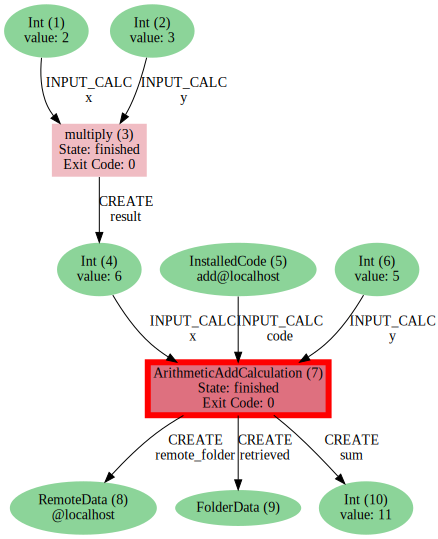

In [21]:
from aiida.tools.visualization import Graph
graph = Graph()
calc_node = orm.load_node(7)
graph.recurse_ancestors(calc_node, annotate_links="both")
graph.add_outgoing(calc_node, annotate_links="both")
graph.graphviz

You can see more details on any process, including its inputs and outputs, using the verdi shell:

In [22]:
%verdi process show 7

Property     Value
-----------  ------------------------------------
type         ArithmeticAddCalculation
state        Finished [0]
pk           7
uuid         c8e17909-71e2-4974-8bfd-2c411b81e9aa
label
description
ctime        2024-08-06 11:34:03.209029+00:00
mtime        2024-08-06 11:34:06.745011+00:00
computer     [1] localhost

Inputs      PK  Type
--------  ----  -------------
code         5  InstalledCode
x            4  Int
y            6  Int

Outputs          PK  Type
-------------  ----  ----------
remote_folder     8  RemoteData
retrieved         9  FolderData
sum              10  Int


## Workflows

So far we have executed each process manually.
AiiDA allows us to automate these steps by linking them together in a *workflow*, whose provenance is stored to ensure reproducibility.
For this tutorial we have prepared a basic `WorkChain` that is already implemented in `aiida-core`.
You can see the code below:

<details>
<summary>Click to show/hide code</summary>

```python
from aiida.engine import ToContext, WorkChain, calcfunction
from aiida.orm import AbstractCode, Int
from aiida.plugins.factories import CalculationFactory

ArithmeticAddCalculation = CalculationFactory('core.arithmetic.add')


@calcfunction
def multiply(x, y):
    return x * y


class MultiplyAddWorkChain(WorkChain):
    """WorkChain to multiply two numbers and add a third, for testing and demonstration purposes."""

    @classmethod
    def define(cls, spec):
        """Specify inputs and outputs."""
        super().define(spec)
        spec.input('x', valid_type=Int)
        spec.input('y', valid_type=Int)
        spec.input('z', valid_type=Int)
        spec.input('code', valid_type=AbstractCode)
        spec.outline(
            cls.multiply,
            cls.add,
            cls.validate_result,
            cls.result,
        )
        spec.output('result', valid_type=Int)
        spec.exit_code(400, 'ERROR_NEGATIVE_NUMBER', message='The result is a negative number.')

    def multiply(self):
        """Multiply two integers."""
        self.ctx.product = multiply(self.inputs.x, self.inputs.y)

    def add(self):
        """Add two numbers using the `ArithmeticAddCalculation` calculation job plugin."""
        inputs = {'x': self.ctx.product, 'y': self.inputs.z, 'code': self.inputs.code}
        future = self.submit(ArithmeticAddCalculation, **inputs)

        return ToContext(addition=future)

    def validate_result(self):
        """Make sure the result is not negative."""
        result = self.ctx.addition.outputs.sum

        if result.value < 0:
            return self.exit_codes.ERROR_NEGATIVE_NUMBER

    def result(self):
        """Add the result to the outputs."""
        self.out('result', self.ctx.addition.outputs.sum)
```
First, we recognize the `multiply` function we have used earlier, decorated as a `calcfunction`.
The `define` class method specifies the `input` and `output` of the `WorkChain`, as well as the `outline`, which are the steps of the workflow.
These steps are provided as methods of the `MultiplyAddWorkChain` class.


Let's import and run the `MultiplyAddWorkChain`. Similar to a `CalcJob`, the `WorkChain` input can be set up using a builder:

In [24]:
from aiida.workflows.arithmetic.multiply_add import MultiplyAddWorkChain

from aiida import orm
builder = MultiplyAddWorkChain.get_builder()
builder.code = orm.load_code(label='add')
builder.x = orm.Int(2)
builder.y = orm.Int(3)
builder.z = orm.Int(5)
builder

Process class: MultiplyAddWorkChain
Inputs:
code: add@localhost
metadata: {}
x: 2
y: 3
z: 5


Once the `WorkChain` input has been set up, we run it with the AiiDA engine:

In [25]:
from aiida import engine
engine.run(builder)

Report: [14|MultiplyAddWorkChain|add]: Submitted the `ArithmeticAddCalculation`: uuid: 3e0155a1-a1d8-4923-a3e4-997b98839b76 (pk: 17) (aiida.calculations:core.arithmetic.add)


{'result': <Int: uuid: d95eb6ad-fc11-4739-97fa-c5eef6b7b2b1 (pk: 20) value: 11>}

Now quickly leave the IPython shell and check the process list:

In [26]:
%verdi process list -a

  PK  Created    Process label             ♻    Process State    Process status
----  ---------  ------------------------  ---  ---------------  ----------------
   3  1m ago     multiply                       ⏹ Finished [0]
   7  42s ago    ArithmeticAddCalculation       ⏹ Finished [0]
  14  6s ago     MultiplyAddWorkChain           ⏹ Finished [0]
  15  5s ago     multiply                       ⏹ Finished [0]
  17  4s ago     ArithmeticAddCalculation       ⏹ Finished [0]

Total results: 5

Report: ♻ Processes marked with check-mark were not run but taken from the cache.
Report: Add the option `-P pk cached_from` to the command to display cache source.
Report: Last time an entry changed state: 0s ago (at 11:34:45 on 2024-08-06)


We can see that the `MultiplyAddWorkChain` and its *child process* should be in the `Finished` state.

We can now generate the full provenance graph for the `WorkChain` with:

```console
$ verdi node graph generate 14
```

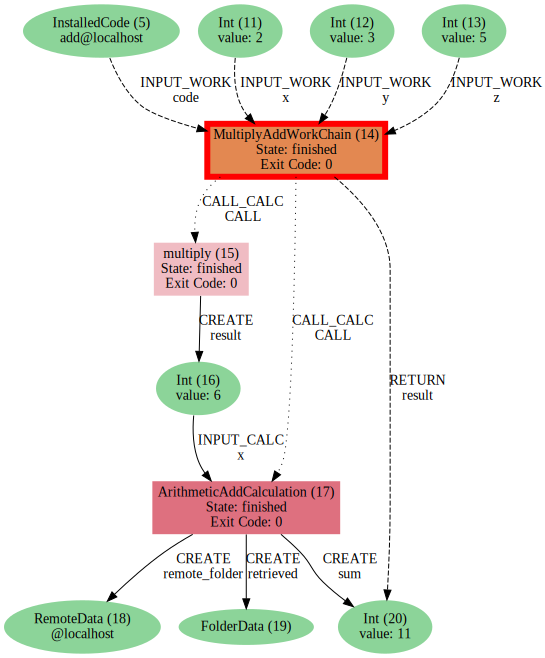

In [27]:
from aiida.tools.visualization import Graph
graph = Graph()
calc_node = orm.load_node(14)
graph.recurse_ancestors(calc_node, annotate_links="both")
graph.recurse_descendants(calc_node, annotate_links="both")
graph.graphviz

# Next Steps

Congratulations! You have completed the first step to becoming an AiiDA expert.

To further enhance your skills, we have compiled several how-to guides tailored for key use cases:

- **Querying and Sharing Your Data**: Once you have run multiple computations, the [Managing Data](3-managing-data.ipynb) guide will show you how to efficiently explore and share your data.

- **Real-World Example**: The [Quantum Espresso](2-qe-pw-aiida.ipynb) guide demonstrates how to run a Quantum Espresso calculation using AiiDA, providing a practical example of its application.

- **Designing a Workflow**: Learn how to encode the logic of a typical scientific workflow with the [EOS Workflow](4-eos-workflow.ipynb) guide.

These resources will help you deepen your understanding and proficiency with AiiDA. Happy exploring!
